In [10]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.v2 import ToImage, ToDtype

from matplotlib import pyplot as plt
import numpy as np
import time

In [11]:
print(torch.cuda.is_available(), torch.cuda.get_device_name())

True NVIDIA GeForce RTX 4060


In [12]:
transforms = transforms.Compose([
    ToImage(),
    ToDtype(torch.float32, scale=True)
])

In [13]:
trainD = datasets.CIFAR10(root="data", train=True, transform=transforms, download=True)
testD = datasets.CIFAR10(root="data", train=False, transform=transforms, download=True)

2 torch.Size([3, 32, 32]) <class 'torchvision.tv_tensors._image.Image'>


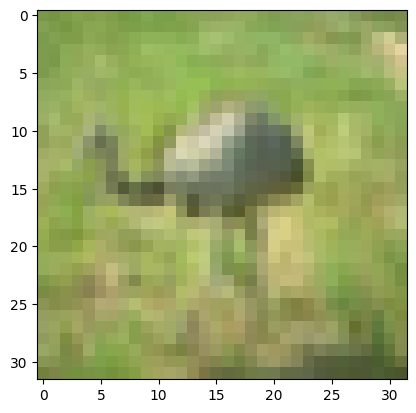

In [14]:
x, label = trainD[np.random.randint(len(trainD))] # 32x32 PIL image, label
plt.imshow(x.permute(1, 2, 0))
print(label, x.size(), type(x))

In [15]:
BATCH_SIZE = 256
DEVICE = torch.accelerator.current_accelerator()

trainDL = DataLoader(trainD, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
testDL = DataLoader(testD, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

In [16]:
class Cifar(nn.Module):
  def __init__(self):
    super().__init__()
    self.labels = {
                    0: "airplane",  
                    1: "automobile", 
                    2: "bird",
                    3: "cat",
                    4: "deer",
                    5: "dog",
                    6: "frog",
                    7: "horse",
                    8: "ship",
                    9: "truck"
                  }
    self.model = nn.Sequential(
      nn.Conv2d(3, 32, 3, padding=1), # 32x32x48
      nn.ReLU(),

      nn.Conv2d(32, 64, 5), # 28x28x64
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # 14x14x64

      nn.Conv2d(64, 126, 7), # 8x8x126
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # 4x4x126

      nn.Flatten(),
      nn.Linear(2016, 512),
      nn.ReLU(),
      nn.Dropout(0.2),

      nn.Linear(512, 10)
    )

  def forward(self, x):
    logits = self.model(x)
    return logits

In [50]:
def train(dataloader, model, loss_fn, optimizer):
  model.train()
  
  for batch_i, (X, y) in enumerate(dataloader):
    X, y = X.to(DEVICE), y.to(DEVICE)
    # get predictions
    preds = model(X)
    # calculate loss
    loss = loss_fn(preds, y)
    # backprop
    loss.backward()
    # gradient descent 
    optimizer.step()    
    optimizer.zero_grad()

    if (batch_i % 50 < 1) or (batch_i == len(dataloader) - 1):
      print(f"Batch {batch_i+1}/{len(dataloader)}, Loss: {loss.item():.4f}")


def test(dataloader, model, loss_fn):
  model.eval()
  loss_t = correct = 0
  size, num_batches = len(dataloader.dataset), len(dataloader)
  
  # run through testing data
  with torch.no_grad():
    for batch_i, (X, y) in enumerate(dataloader):
      X, y = X.to(DEVICE), y.to(DEVICE)

      # get model preds
      preds = model(X)
      loss_t += loss_fn(preds, y).item()
      correct += (preds.argmax(dim=1) == y).type(torch.float).sum().item()
    
  # calculate average loss & accuracy
  avg_loss = loss_t / num_batches  
  accuracy = correct / size * 100

  print(f"TEST, Accuracy: {accuracy:.2f}%, Loss: {avg_loss:.4f}")

  return accuracy, avg_loss
  

def fit(model, epochs: int):

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
  loss_fn = torch.nn.CrossEntropyLoss()

  accuracies, losses = [], []

  print("Starting...")
  for epoch in range(epochs):
    print("\nEpoch", epoch+1)

    train(trainDL, model, loss_fn, optimizer)
    acc, loss = test(testDL, model, loss_fn )

    accuracies.append(acc)
    losses.append(loss)

  torch.save(model.state_dict(), "model_weights.pth")
  print("Done!\n Weights saved to 'model_weights.pth'")
  return accuracies, losses


In [51]:
EPOCHS = 10
model = Cifar().to(DEVICE)

acc, loss = fit(model, EPOCHS)


Starting...

Epoch 1
Batch 1/196, Loss: 2.3038
Batch 51/196, Loss: 1.8193
Batch 101/196, Loss: 1.6122
Batch 151/196, Loss: 1.4829
Batch 196/196, Loss: 1.3731
TEST, Accuracy: 50.08%, Loss: 1.3686

Epoch 2
Batch 1/196, Loss: 1.3167
Batch 51/196, Loss: 1.3952
Batch 101/196, Loss: 1.2075
Batch 151/196, Loss: 1.2356
Batch 196/196, Loss: 1.2016
TEST, Accuracy: 57.18%, Loss: 1.1915

Epoch 3
Batch 1/196, Loss: 1.2227
Batch 51/196, Loss: 1.0530
Batch 101/196, Loss: 1.0720
Batch 151/196, Loss: 1.0911
Batch 196/196, Loss: 0.9398
TEST, Accuracy: 62.20%, Loss: 1.0617

Epoch 4
Batch 1/196, Loss: 0.9658
Batch 51/196, Loss: 1.0919
Batch 101/196, Loss: 0.9804
Batch 151/196, Loss: 0.8395
Batch 196/196, Loss: 0.9599
TEST, Accuracy: 65.26%, Loss: 0.9900

Epoch 5
Batch 1/196, Loss: 0.9201
Batch 51/196, Loss: 0.8889
Batch 101/196, Loss: 0.9119
Batch 151/196, Loss: 0.8751
Batch 196/196, Loss: 0.9535
TEST, Accuracy: 68.32%, Loss: 0.9023

Epoch 6
Batch 1/196, Loss: 0.8260
Batch 51/196, Loss: 0.7953
Batch 101/1

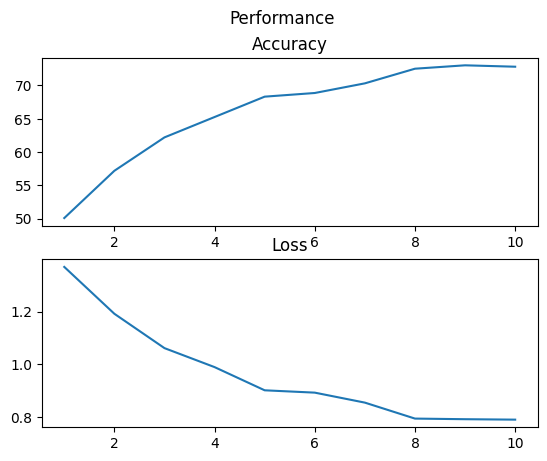

In [52]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle("Performance")

epochs = range(1, EPOCHS+1)

ax1.plot(epochs, acc)
ax1.set_title("Accuracy")

ax2.plot(epochs, loss)
ax2.set_title("Loss")
plt.savefig(f"performance_{int(time.time())}")

In [56]:
def predict(model):
  model.eval()

  X, label = testD[np.random.randint(len(testD))] # 32x32 PIL image, label
  plt.imshow(X.permute(1, 2, 0))
  X = X.unsqueeze(0).to(DEVICE)
  
  with torch.no_grad():
    pred = model(X).argmax(dim=1).item()

  print(f"Prediction: {model.labels[pred]} ({pred}), Truth: {model.labels[label]} ({label})") 


Prediction: airplane (0), Truth: airplane (0)


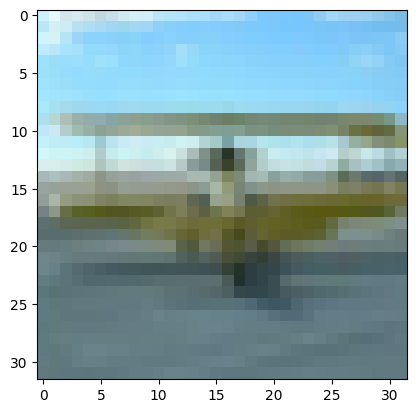

In [63]:
predict(model)